In [1]:
from scipy import misc
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [69]:
import numpy as np
import re
from scipy import linalg
import scipy.ndimage as ndi
from six.moves import range
import os
import threading

def transform_matrix_offset_center(matrix, x, y):
    o_x = float(x) / 2 + 0.5
    o_y = float(y) / 2 + 0.5
    offset_matrix = np.array([[1, 0, o_x], [0, 1, o_y], [0, 0, 1]])
    reset_matrix = np.array([[1, 0, -o_x], [0, 1, -o_y], [0, 0, 1]])
    transform_matrix = np.dot(np.dot(offset_matrix, matrix), reset_matrix)
    return transform_matrix

def apply_transform(x, transform_matrix, channel_index=2, fill_mode='nearest', cval=0.):
    x = np.rollaxis(x, channel_index, 0)
    final_affine_matrix = transform_matrix[:2, :2]
    final_offset = transform_matrix[:2, 2]
    channel_images = [ndi.interpolation.affine_transform(x_channel, final_affine_matrix,
                      final_offset, order=0, mode=fill_mode, cval=cval) for x_channel in x]
    x = np.stack(channel_images, axis=0)
    x = np.rollaxis(x, 0, channel_index+1)
    return x


def image_rotation(x, rg,step, row_index=0, col_index=1, channel_index=2,
                    fill_mode='nearest', cval=0.):
    image_set = np.zeros((np.expand_dims(x,axis=0).shape),dtype=np.uint8)
    for i in range(-rg,rg,step):
        theta = (np.pi  * i)/ 180
        rotation_matrix = np.array([[np.cos(theta), -np.sin(theta), 0],
                                [np.sin(theta), np.cos(theta), 0],
                                [0, 0, 1]])

        h, w = x.shape[row_index], x.shape[col_index]
        transform_matrix = transform_matrix_offset_center(rotation_matrix, h, w)
        new = apply_transform(x, transform_matrix, channel_index, fill_mode, cval)
        image_set = np.vstack((image_set,np.expand_dims(new,axis=0)))
    return image_set

def image_shear(x,  row_index=0, col_index=1, channel_index=2,
                 fill_mode='nearest', cval=0.):
    shear = [-0.25,0.25,6.3,9.5,-9.5,2.95,-2.95,0]
    image_set = np.zeros((np.expand_dims(x,axis=0).shape),dtype=np.uint8)
    for i in shear:
        shear_matrix = np.array([[1, -np.sin(i), 0],
                             [0, np.cos(i), 0],
                             [0, 0, 1]])
        h, w = x.shape[row_index], x.shape[col_index]
        transform_matrix = transform_matrix_offset_center(shear_matrix, h, w)
        new = apply_transform(x, transform_matrix, channel_index, fill_mode, cval)
        image_set = np.vstack((image_set,np.expand_dims(new,axis=0)))
    return image_set[1:]



def image_zoom(x, zoom_range,step, row_index=0, col_index=1, channel_index=2,
                fill_mode='nearest', cval=0.):
    if len(zoom_range) != 2:
        raise Exception('zoom_range should be a tuple or list of two floats. '
                        'Received arg: ', zoom_range)

    if zoom_range[0] == 1 and zoom_range[1] == 1:
        zx, zy = 1, 1
    else:
        image_set = np.zeros((np.expand_dims(x,axis=0).shape),dtype=np.uint8)
        for zx in np.arange(zoom_range[0],zoom_range[1],step):
            for zy in np.arange(zoom_range[0],zoom_range[1],step):
                zoom_matrix = np.array([[zx, 0, 0],
                            [0, zy, 0],
                            [0, 0, 1]])

                h, w = x.shape[row_index], x.shape[col_index]
                transform_matrix = transform_matrix_offset_center(zoom_matrix, h, w)
                new = apply_transform(x, transform_matrix, channel_index, fill_mode, cval)
                image_set = np.vstack((image_set,np.expand_dims(new,axis=0)))
    return image_set[1:]

def image_shift(x, wrg, hrg,step ,row_index=0, col_index=1, channel_index=2,
                 fill_mode='nearest', cval=0.):
    h,w = x.shape[row_index],x.shape[col_index]
    image_set = np.zeros((np.expand_dims(x,axis=0).shape),dtype=np.uint8)
    for tx in np.arange(-hrg*h,hrg*h,step):
        for ty in np.arange(-wrg*h,wrg*h,step):
            translation_matrix = np.array([[1, 0, tx],
                                   [0, 1, ty],
                                   [0, 0, 1]])

            transform_matrix = translation_matrix  # no need to do offset
            new = apply_transform(x, transform_matrix, channel_index, fill_mode, cval)
            image_set = np.vstack((image_set,np.expand_dims(new,axis=0)))
    return image_set[1:]

def random_shift(x, wrg, hrg, row_index=0, col_index=1, channel_index=2,
                 fill_mode='nearest', cval=0.):
    h, w = x.shape[row_index], x.shape[col_index]
    tx = np.random.uniform(-hrg, hrg) * 2
    ty = np.random.uniform(-wrg, wrg) * w
    print tx,ty
    translation_matrix = np.array([[1, 0, tx],
                                   [0, 1, ty],
                                   [0, 0, 1]])

    transform_matrix = translation_matrix  # no need to do offset
    x = apply_transform(x, transform_matrix, channel_index, fill_mode, cval)
    return x


In [16]:
from PIL import Image
from matplotlib import cm

image = np.array(Image.open('/home/mckc/All Data/Abhay_0.jpg'))

In [18]:
import dlib
detector = dlib.get_frontal_face_detector()
faces = detector(image, 1)
for a,b in enumerate(faces):
    face = np.array(image)[b.top():b.bottom(),b.left():b.right(),:]  

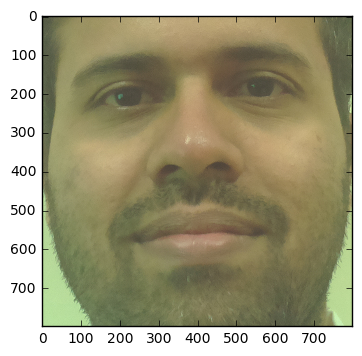

In [19]:
plt.imshow(face)

In [77]:
a = image_shift(np.array(face),.1,.1,40)
a.shape

(16, 799, 799, 3)

In [84]:
import time
start = time.clock()
a= image_zoom(face,[0.8,1.2],0.1)
print a.shape[0]
a = image_rotation(face,15,3)
print a.shape[0]
a = image_shear(face)
print a.shape[0]
a = image_shift(np.array(face),.1,.1,40)
print a.shape[0]
print '\\n',time.clock()-start 

16
11
8
16
\n 3.301522


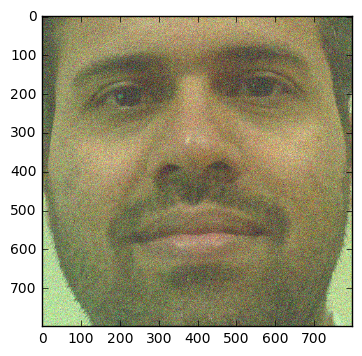

In [130]:
from skimage.util import random_noise
noisyImage = random_noise(face, mode='gaussian')
#noisyImage = face + 0.0000004 * face.std() * np.random.random(face.shape)
plt.imshow(noisyImage)

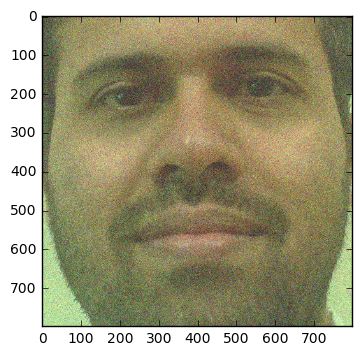

In [131]:
noisyImage = random_noise(face, mode='localvar')
#noisyImage = face + 0.0000004 * face.std() * np.random.random(face.shape)
plt.imshow(noisyImage)

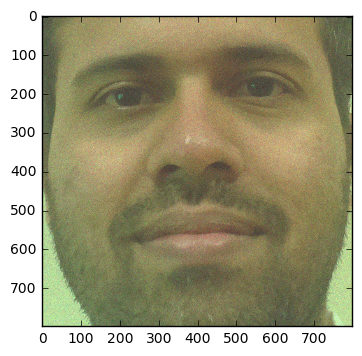

In [132]:
noisyImage = random_noise(face, mode='poisson')
#noisyImage = face + 0.0000004 * face.std() * np.random.random(face.shape)
plt.imshow(noisyImage)

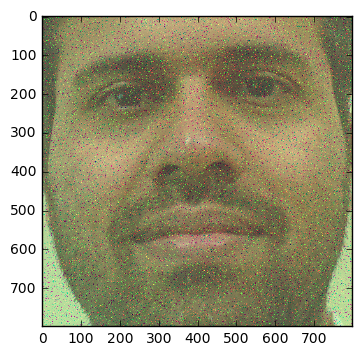

In [133]:
noisyImage = random_noise(face, mode='s&p')
#noisyImage = face + 0.0000004 * face.std() * np.random.random(face.shape)
plt.imshow(noisyImage)

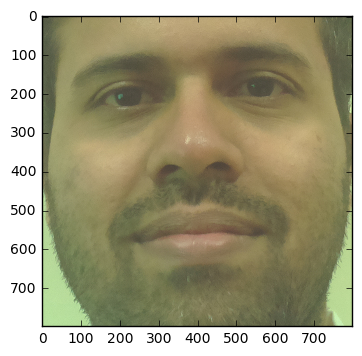

In [100]:
plt.imshow(face)

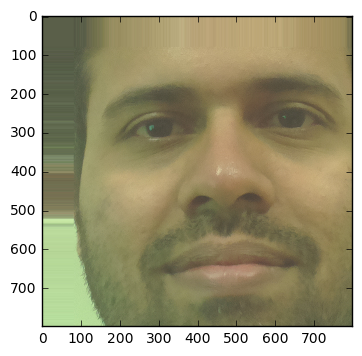

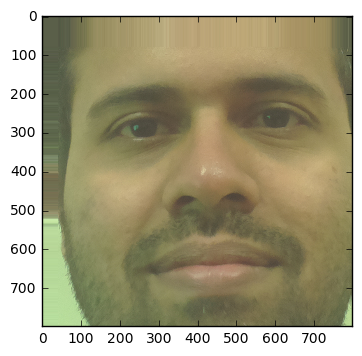

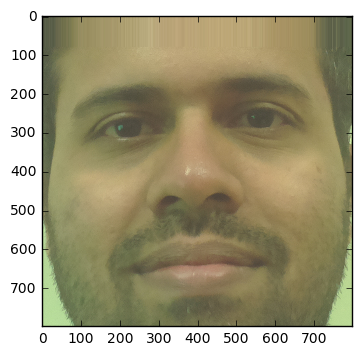

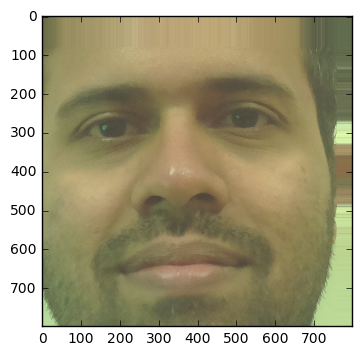

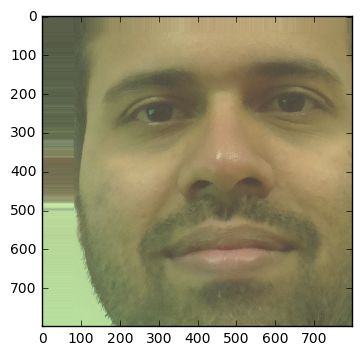

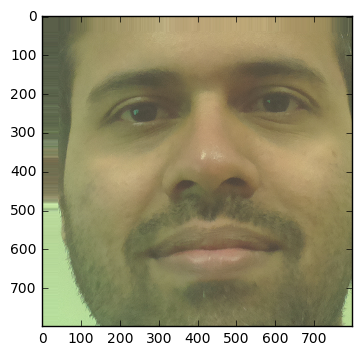

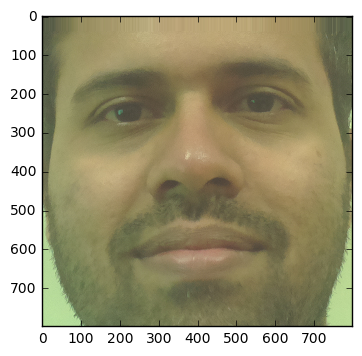

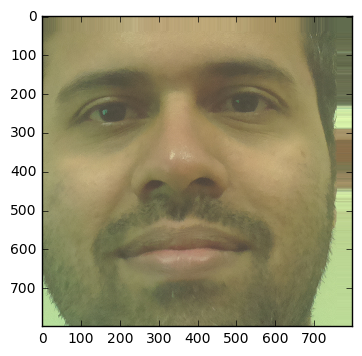

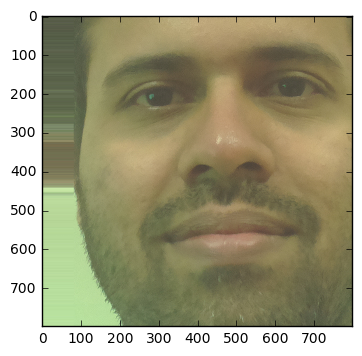

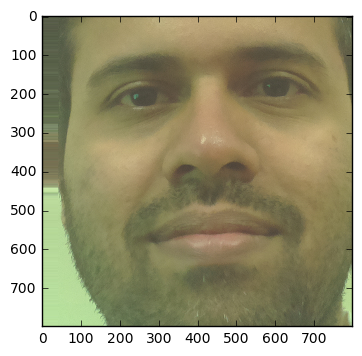

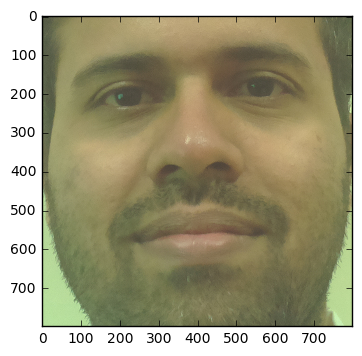

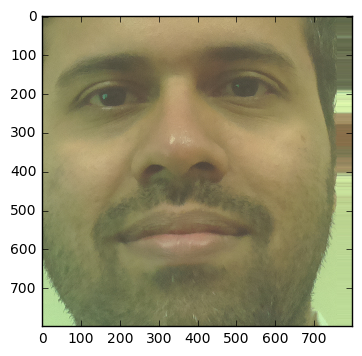

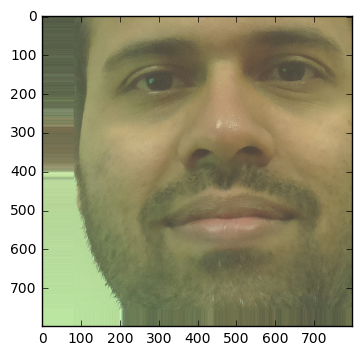

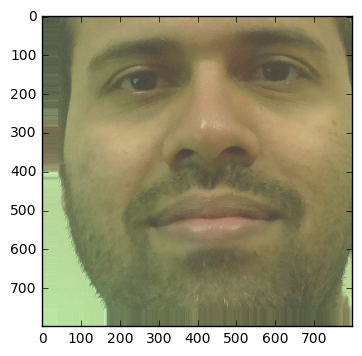

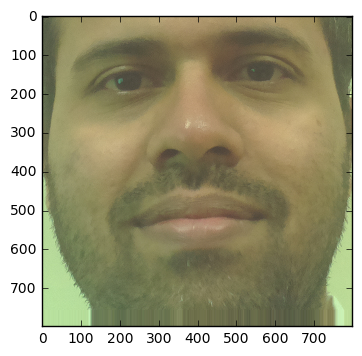

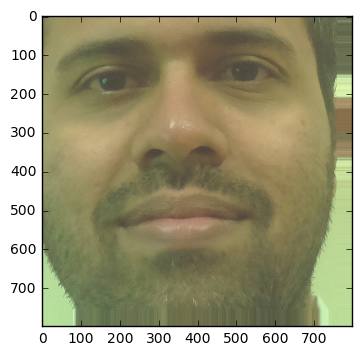

In [78]:
for i in range(a.shape[0]):
    plt.figure(i)
    plt.imshow(a[i])
plt.show()